#### Seq2Seq를 통해 한강의 수위를 학습시키는 코드입니다. 사용된 데이터는 (한강대교, 잠수교, 청담대교) 3개 대교의 수위를 포함하고 있습니다. 학습을 바탕으로 새로운 데이터를 불러와서 예측모델에 넣고 맞추는 부분을 포함하고 있습니다.

In [1]:
!pwd
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(0) # gpu idx

/home/hyejoo/work/repos/Capstone_2020/capstone1


In [2]:
from random import randint
from numpy import array
#from numpy import argmax
#from numpy import array_equal
#from keras.utils import to_categorical
from keras.callbacks import CSVLogger
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
import keras
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from DDUtil import *

Using TensorFlow backend.
/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hyejoo/.venv/py367tf/lib/python3.6/sit

In [3]:
 np.random.seed (1214)

In [4]:
import tensorflow
tensorflow.__version__

'1.14.0'

In [5]:
fnbasis = GetTimeString()
print(fnbasis)

20200624_135257


In [6]:
outDir = 'out'
to_Train = True

In [7]:
import os
try:
    if not os.path.exists(outDir):
        os.makedirs(outDir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [8]:
%%time
df = pd.read_csv('./add_timestamp_data.csv')

CPU times: user 320 ms, sys: 20.8 ms, total: 341 ms
Wall time: 340 ms


In [9]:
print('{} samples per day'.format(6*24))

144 samples per day


In [11]:
data = df.iloc[:, 2:5]
data.head(5)

,한강수위,잠수수위,청담수위
0,0.90,3.1,1.25
1,0.89,3.1,1.24
2,0.88,3.1,1.27
3,0.87,3.1,1.25
4,0.86,3.1,1.25


In [12]:
std1 = data.std().copy()
mean1 = data.mean().copy()

In [13]:
std1

한강수위    0.535533
잠수수위    0.550382
청담수위    0.648431
dtype: float64

In [14]:
mean1

한강수위    0.940090
잠수수위    3.114161
청담수위    1.431878
dtype: float64

In [15]:
normalized_data=data#(data-mean1)/std1
data = normalized_data

In [16]:
data_o = np.array(data) #data_o = np.expand_dims(data, axis=1) #

In [18]:
if len(data_o.shape)==1: # single axis is being used
    print(data_o.shape)
    data_o = np.expand_dims(data_o, axis=1)
print(data_o.shape)

(546337, 3)


In [19]:
data_o.shape[0]

546337

In [20]:
# configure problem
#n_features = 50 + 1 # cardinality
n_features = data_o.shape[1] # cardinality
n_steps_in = 144#100+44
n_steps_out = 72#72

latent_dim = n_steps_in#256#128

### Settings

In [21]:
nExtract = 60000#1000000

In [22]:
print('n_features={}'.format(n_features))

n_features=3


In [23]:
window_width = n_steps_in + n_steps_out

In [24]:
n_samples = data_o.shape[0] // window_width
print(n_samples)

2529


In [25]:
def LoadDataPop(data, n_in=144, n_out=72, nExtract=-1, verbose=False):
    import numpy as np
    
    n_features = np.shape(data)[1]
    L = np.shape(data)[0]
    
    if nExtract==-1:
        ndata = L// (n_in+n_out)
    else:
        ndata = nExtract
        
    if verbose:
        print(L,n_features)
    
    vdata_in = []
    vdata_out = []
    vtarget_in = []
    vidx =[]
    for i in tqdm(range(ndata)):
        #r = i* (n_in+n_out)
        r = random.randint(0, n_in - 1 - n_out) * (n_in+n_out)
        
        if verbose:
            print('{}\tin {}~{} out {}~{}'.format(i, r,r+n_in, r+n_in,r+n_in+n_out))
      
        arr1_in = data[r:r+n_in, : ]
        arr1_out = data[r+n_in:r+n_in+n_out,:]
        
        #target_in = np.concatenate(([[0.0 for _ in range(n_features)]] , data[r+n_in:r+n_in+n_out-1,:]), axis=0) #x_in[:-1]
        # The output of the generator must be ([encoder_input, decoder_input], [decoder_output])
        #    decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
            
        target_in = np.array([[0.0 for _ in range(n_features)]]*72)
            
        vdata_in.append(arr1_in)
        vdata_out.append(arr1_out)
        vtarget_in.append(target_in)
        vidx.append(r)
                
    return np.array(vdata_in),  np.array(vtarget_in), np.array(vdata_out), np.array(vidx)

In [26]:
vdata_in, vtarget_in,  vdata_out, vidx = LoadDataPop(data_o, n_in=n_steps_in,n_out=n_steps_out,nExtract = nExtract, verbose= False)

100%|██████████| 60000/60000 [00:01<00:00, 40270.69it/s]


In [27]:
vdata_in.shape, vdata_out.shape, vtarget_in.shape

((60000, 144, 3), (60000, 72, 3), (60000, 72, 3))

In [28]:
vtarget_in[0].shape

(72, 3)

In [29]:
#vtarget_in[0]

In [30]:
n_training = vdata_in.shape[0] * 7 // 10
print(n_training)

42000


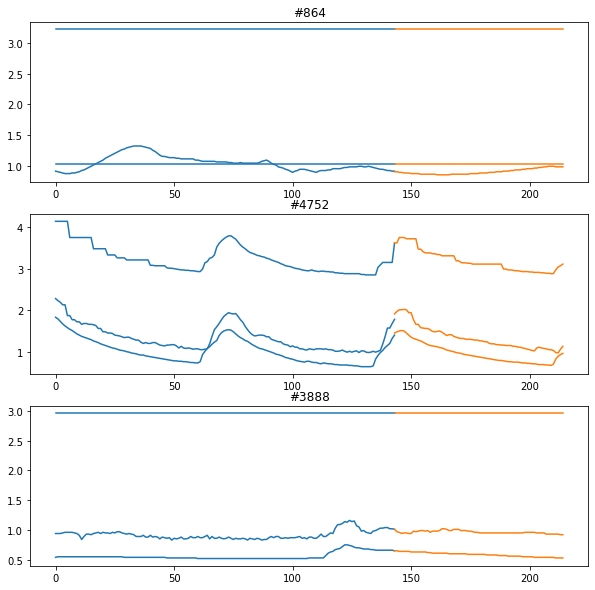

In [31]:
n_samples_to_draw = 3
nwidth = n_samples_to_draw
a = n_samples_to_draw//nwidth

f, axarr = plt.subplots(n_samples_to_draw, 1, figsize=(10,10))
for i in range(n_samples_to_draw):
    idx1 =  random.randint(0, len(vdata_in))
    xx = i % nwidth
    yy = i // nwidth
    #print(yy, xx)
    
    t_in = np.arange(n_steps_in)
    t = np.arange(n_steps_in+n_steps_out)
    t_out = n_steps_in+np.arange(n_steps_out)-1
   
    x_in=  vdata_in[idx1]
    x_out = vdata_out[idx1]
    
    axarr[i].set_title('#{}'.format(vidx[idx1]))
    
    axarr[i].plot(t_in, x_in,color='C0')
    axarr[i].plot(t_out, x_out,color='C1')
    #axarr[i].legend(legends)

### data split

In [32]:
data_in_train = vdata_in[:n_training, :]
data_out_train = vdata_out[:n_training, :]
data_targetin_train = vtarget_in[:n_training, :]

In [33]:
data_in_test = vdata_in[n_training:, :]
data_out_test = vdata_out[n_training:, :]
data_targetin_test = vtarget_in[n_training:, :]

In [34]:
#pickle:
import pickle
datasave = [None] * 5
datasave[0] = data_in_test
datasave[1] = data_out_test
datasave[2] = data_targetin_test

datasave[3] = std1
datasave[4] = mean1
#file = open(outDir+'/data_test_72.p', 'wb')
fn_pickle = outDir+'/data_test_{}.p'.format(fnbasis)
file1 = open(fn_pickle, 'wb')
print(fn_pickle)

pickle.dump(datasave, file1)
# close the file
file1.close()

out/data_test_20200624_135257.p


In [35]:
data_in_train.shape, data_in_test.shape

((42000, 144, 3), (18000, 144, 3))

[encoder_input, decoder_input], decoder_output

In [36]:
encoder_input = data_in_train
decoder_input = data_targetin_train
decoder_output = data_out_train

In [37]:
n_training

42000

In [38]:
nb_epoch = 15

In [39]:
# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

In [40]:
num_input_features = n_features
#hidden_neurons = latent_dim

In [41]:
nlayers = [latent_dim] 
#nlayers = [latent_dim, latent_dim] 

#Total params: 380,021 # Number of hidden neuros in each layer of the encoder and decoderlearning_rate = 0.01
#Total params: 879,413 Trainable params: 879,413 : stack 4

#layers = [latent_dim] #130,325
nb_stack = len(nlayers)
decay = 0 # Learning rate decay

learning_rate = 0.001


#optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)
optimiser = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9,  decay=decay, clipnorm=1)
#optimiser = keras.optimizers.SGD(lr=learning_rate, momentum=0.0, decay=0.0, nesterov=False)
num_input_features = n_features#1 # The dimensionality of the input at each time step. In this case a 1D signal.
num_output_features = n_features#1 # The dimensionality of the output at each time step. In this case a 1D signal.
# There is no reason for the input sequence to be of same dimension as the ouput sequence.
# For instance, using 3 input signals: consumer confidence, inflation and house prices to predict the future house prices.

#loss_fn = keras.losses.MeanSquaredError()

loss = "mse" # Other loss functions are possible, see Keras documentation.


In [42]:
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))
#encoder_inputs = keras.layers.BatchNormalization()(encoder_inputs)
#encoder_inputs = keras.layers.BatchNormalization(name='Encoder-Batchnorm-1')(encoder_inputs)


W0624 13:53:55.611245 139913318463296 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 13:53:55.612105 139913318463296 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [43]:
# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in nlayers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]
   

W0624 13:53:56.885983 139913318463296 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [44]:
# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, n_features))
#decoder_inputs = keras.layers.BatchNormalization(name='Decoder-Batchnorm-1')(decoder_inputs)
decoder_cells = []
for hidden_neurons in nlayers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

In [45]:
# Create a model using the functional API provided by Keras.
# The functional API is great, it gives an amazing amount of freedom in architecture of your NN.
# A read worth your time: https://keras.io/getting-started/functional-api-guide/ 
## 다중 입력이므로 Input을 []로 감싸서 2개를 대입
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer=optimiser, loss=loss)

W0624 13:53:57.913272 139913318463296 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
rnn_1 (RNN)                     [(None, 144), (None, 63936       input_1[0][0]                    
__________________________________________________________________________________________________
rnn_2 (RNN)                     [(None, None, 144),  63936       input_2[0][0]                    
                                                                 rnn_1[0][1]                      
__________

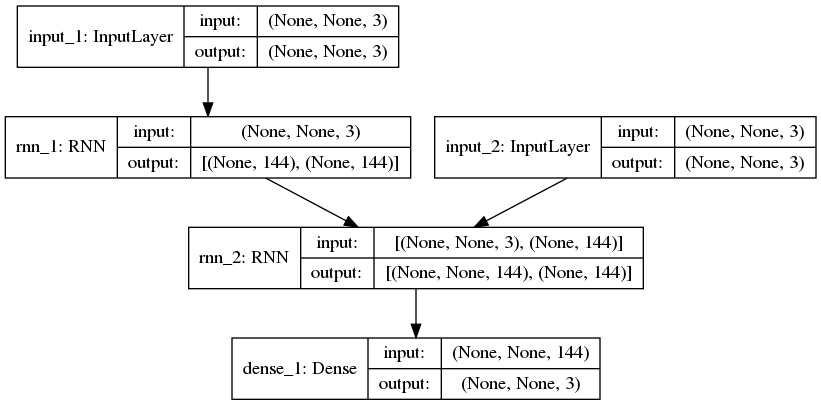

In [47]:
from keras.utils import plot_model
plot_model(model, to_file='{}/model_{}.png'.format(outDir, 'train'), show_shapes=True)
#plot_model(model, to_file='{}/model{}.svg'.format(outDir, ttl1), show_shapes=True)
from IPython.display import Image
Image('{}/model_{}.png'.format(outDir, 'train'))

In [48]:
#!wget https://raw.githubusercontent.com/LukeTonin/keras-seq-2-seq-signal-prediction/caca07cac3a5d3a0c651af950c63feb9d96dc14d/utils.py

In [49]:
batch_size = 64
num_samples = n_training #10000
steps_per_epoch = num_samples // batch_size
input_sequence_length = n_steps_in
target_sequence_length = n_steps_out
#n_steps_in = 144#100+44
#n_steps_out = 72#72

In [50]:
num_samples, batch_size, steps_per_epoch

(42000, 64, 656)

In [51]:
verbose = 1

In [52]:
hist=model.fit([encoder_input, decoder_input], decoder_output, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

W0624 13:54:12.721083 139913318463296 deprecation.py:323] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0624 13:54:13.258426 139913318463296 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0624 13:54:13.262611 139913318463296 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/15
42000/42000 [==============================] - 105s 2ms/step - loss: 0.1116
Epoch 2/15
42000/42000 [==============================] - 104s 2ms/step - loss: 0.0238
Epoch 3/15
42000/42000 [==============================] - 103s 2ms/step - loss: 0.0146
Epoch 4/15
42000/42000 [==============================] - 103s 2ms/step - loss: 0.0090
Epoch 5/15
42000/42000 [==============================] - 103s 2ms/step - loss: 0.0057
Epoch 6/15
42000/42000 [==============================] - 103s 2ms/step - loss: 0.0097
Epoch 7/15
42000/42000 [==============================] - 104s 2ms/step - loss: 0.0037
Epoch 8/15
42000/42000 [==============================] - 104s 2ms/step - loss: 0.0036
Epoch 9/15
42000/42000 [==============================] - 103s 2ms/step - loss: 0.0027
Epoch 10/15
42000/42000 [==============================] - 103s 2ms/step - loss: 0.0023
Epoch 11/15
42000/42000 [==============================] - 104s 2ms/step - loss: 0.0020
Epoch 12/15
42000/42000 [================

In [53]:
fn_model = '{}/s2s_model_hg1_train_tot{}_batch{}_stack{}_ep{}_{}.h5'.format(outDir,vdata_in.shape[0],batch_size, nb_stack, nb_epoch, fnbasis)
model.save(fn_model)
print(fn_model)

out/s2s_model_hg1_train_tot60000_batch64_stack1_ep15_20200624_135257.h5


/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer rnn_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn_1/while/Exit_2:0' shape=(?, 144) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


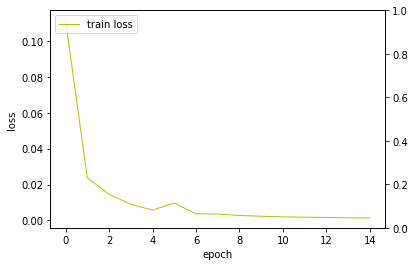

In [54]:
if True:#to_Train:
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss', linewidth=1)
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

In [55]:
def get_a_single_test_data(data_in_test):
    r = data_in_test.shape[0]
    idx =  random.randint(0, r)
    print('{} of {}'.format(idx, r))
        
    x_encoder_test = data_in_test[idx]
    x_decoder_test = data_targetin_test[idx]
    y_test = data_out_test[idx]
    
    x_encoder_test = np.expand_dims(x_encoder_test, axis=0)
    x_decoder_test = np.expand_dims(x_decoder_test, axis=0)
    y_test = np.expand_dims(y_test, axis=0)

    return x_encoder_test, x_decoder_test, y_test, idx

In [56]:
def test(figsize=(5,5)):
    x_encoder_test, x_decoder_test, y_test, idx = get_a_single_test_data(data_in_test)
    print(x_encoder_test.shape, x_decoder_test.shape)
    #(x_encoder_test, x_decoder_test), y_test = next(test_data_generator)
    y_test_predicted = model.predict([x_encoder_test, x_decoder_test])
    
    y_test_predicted = y_test_predicted[0]
    y_test = y_test[0]
    x_encoder_test = x_encoder_test[0]
    x_decoder_test = x_decoder_test[0]
    
    print(y_test_predicted.shape, x_encoder_test.shape)
    #std1 = data.std()
    
    
    #mean1 = data.mean()
    for i in range(y_test_predicted.shape[1]):
        
        y_test_predicted[:, i] = y_test_predicted[:, i]# * std1[i] + mean1[i]
        y_test[:, i] = y_test[:, i]# * std1[i] + mean1[i]
        x_encoder_test[:, i] = x_encoder_test[:, i] #* std1[i] + mean1[i]
    
    #normalized_data=(data-data.mean())/data.std()
        
    idx_plot=0

    t = np.arange(144+72)
    n_steps_in = 144
    t_in = np.arange(n_steps_in)
    t_predict = t[n_steps_in:]-1
    plt.figure(figsize=figsize)
    plt.plot(t_in, x_encoder_test,color='C0')
    plt.plot(t_predict, y_test, color='C2')
    plt.plot(t_predict, y_test_predicted,color='C1') #orange --> pre
    plt.title('# {}'.format(idx))

946 of 18000
(1, 144, 3) (1, 72, 3)
(72, 3) (144, 3)
4775 of 18000
(1, 144, 3) (1, 72, 3)
(72, 3) (144, 3)
14577 of 18000
(1, 144, 3) (1, 72, 3)
(72, 3) (144, 3)
12278 of 18000
(1, 144, 3) (1, 72, 3)
(72, 3) (144, 3)
4991 of 18000
(1, 144, 3) (1, 72, 3)
(72, 3) (144, 3)


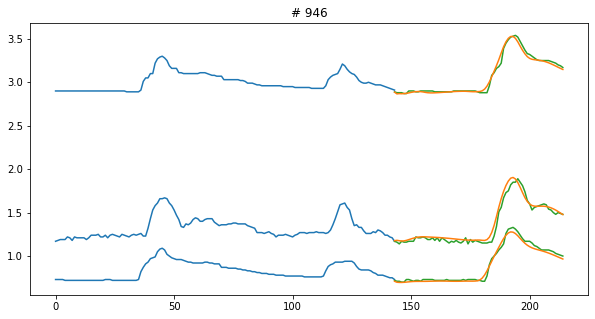

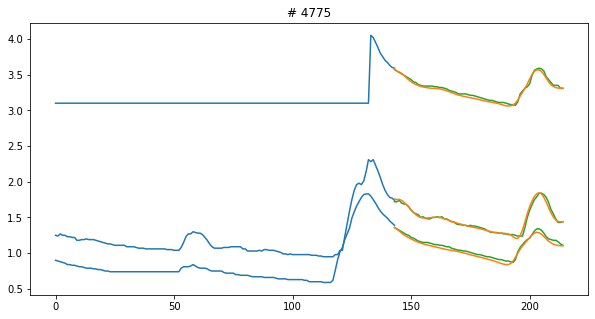

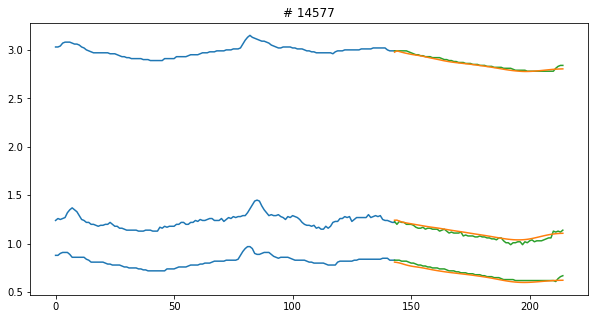

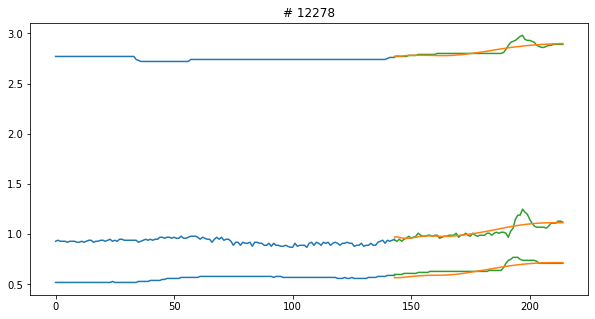

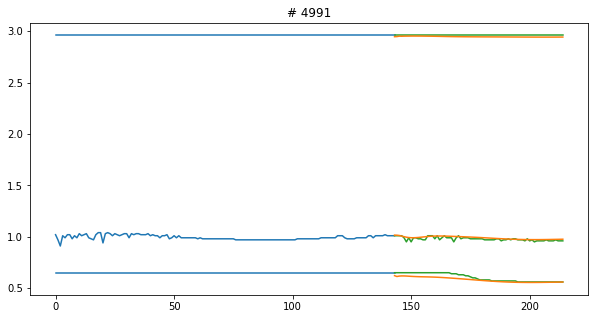

In [57]:
for i in range(5):
    test(figsize=(10,5))

In [58]:
print(fn_model)   #학습한 모델
print(fn_pickle)  #사용된 데이터

out/s2s_model_hg1_train_tot60000_batch64_stack1_ep15_20200624_135257.h5
out/data_test_20200624_135257.p


In [60]:
datasave = [None] * 2
datasave[0] = fn_model
datasave[1] = fn_pickle

fn_pickle = outDir+'/lastfiles.p'
file1 = open(fn_pickle, 'wb')
print(fn_pickle)
pickle.dump(datasave, file1)
# close the file
file1.close()

out/lastfiles.p


### 테스트 및 예측 모델 저장

In [115]:
fn_realtime='test_20200623_150651.csv'    #학습 안한 데이터
df = pd.read_csv(fn_realtime)
#df= df.drop(df.columns[0], axis=1)
df = df.iloc[:, 1:4]
print(df)

dataRecent = np.array(df)
type(dataRecent)

for i in range(3):
    #dataRecent[:,i] = (dataRecent[:,i]-mean1[i]) / std1[i]
    print( i, mean1[i],  std1[i])
dataf = dataRecent

     한강수위  잠수수위  청담수위
0    1.10  3.37  1.50
1    1.12  3.40  1.52
2    1.14  3.42  1.54
3    1.16  3.44  1.57
4    1.18  3.46  1.60
..    ...   ...   ...
283  0.85  3.13  1.24
284  0.86  3.14  1.24
285  0.87  3.14  1.26
286  0.87  3.15  1.26
287  0.88  3.15  1.26

[288 rows x 3 columns]
0 0.9400901370910861 0.5355331435891312
1 3.1141610788616094 0.5503821562872847
2 1.4318782343819643 0.648430500155955


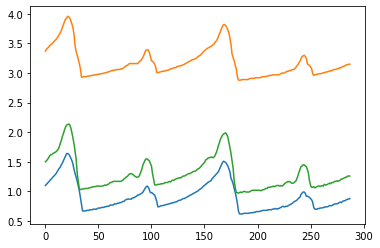

In [116]:
#plt.plot(x_in_keep[0])
plt.plot(dataf)

In [223]:
encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

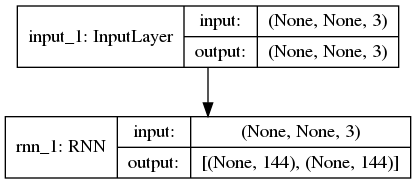

In [224]:
from keras.utils import plot_model
plot_model(encoder_predict_model, to_file='{}/model_{}.png'.format(outDir, 'encoder_predict_model'), show_shapes=True)
#plot_model(model, to_file='{}/model{}.svg'.format(outDir, ttl1), show_shapes=True)
#from IPython.display import Image
Image('{}/model_{}.png'.format(outDir, 'encoder_predict_model'))

In [225]:
# Read layers backwards to fit the format of initial_state
# For some reason, the states of the model are order backwards (state of the first layer at the end of the list)
# If instead of a GRU you were using an LSTM Cell, you would have to append two Input tensors since the LSTM has 2 states.
for hidden_neurons in nlayers[::-1]:
    # One state for GRU
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))



In [226]:
fn_model = 'encoder_hello_generator.h5'
encoder_predict_model.save(fn_model)    #prediction모델 저장

In [228]:
decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

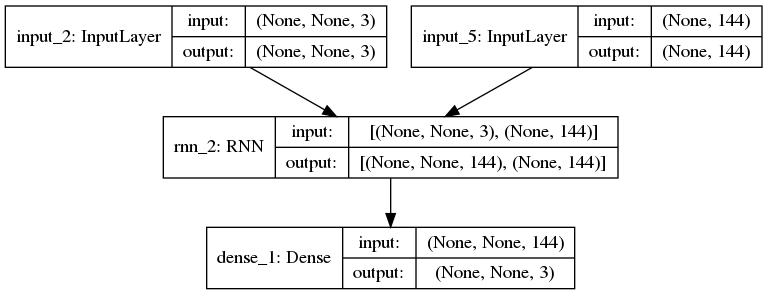

In [229]:
from keras.utils import plot_model
plot_model(decoder_predict_model, to_file='{}/model_{}.png'.format(outDir, 'decoder_predict_model'), show_shapes=True)
#plot_model(model, to_file='{}/model{}.svg'.format(outDir, ttl1), show_shapes=True)
#from IPython.display import Image
Image('{}/model_{}.png'.format(outDir, 'decoder_predict_model'))

In [230]:
# Let's define a small function that predicts based on the trained encoder and decoder models

def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict, batch_size=1):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 3))
    print(decoder_input.shape)

    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)
    

In [231]:
#len(np.shape(vdata_in))

In [232]:
#fn_model = '{}/s2s_model_hg1_train_tot{}_batch{}_stack{}_ep{}_{}.h5'.format(outDir,vdata_in.shape[0],batch_size, nb_stack, nb_epoch, fnbasis)
#model.save(fn_model)

fn_model = 'decoder_hello_generator.h5'
decoder_predict_model.save(fn_model)    #prediction모델 저장

/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer rnn_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_5:0' shape=(?, 144) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [242]:
from keras.models import load_model
 
# load model
encoder_predict_model2 = load_model(fn_model)

/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [243]:
num_steps_to_predict = 36*2
offset = 40
vdata_in = np.expand_dims(dataf[offset:offset+144], 0)
vdata_out = np.expand_dims(dataf[offset+144:offset+144+num_steps_to_predict], 0)
np.shape(vdata_in),np.shape(vdata_out)
len(np.shape(vdata_in))

3

In [244]:
#vdata_in

In [245]:
#len(np.shape(vdata_in)) ==3
if len(np.shape(vdata_in)) ==2:
    x_test =np.expand_dims(vdata_in, axis=0)
else:
    x_test = np.array(vdata_in)

In [246]:
x_test.shape

(1, 144, 3)

In [247]:
y_test_predicted = predict(x_test, encoder_predict_model, decoder_predict_model, num_steps_to_predict)
print(y_test_predicted.shape)

(1, 1, 3)
(1, 72, 3)


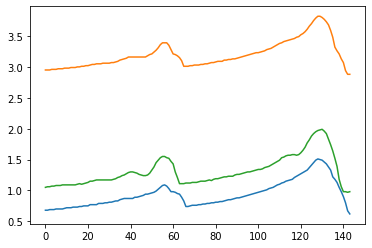

In [248]:
plt.plot(x_test[0])

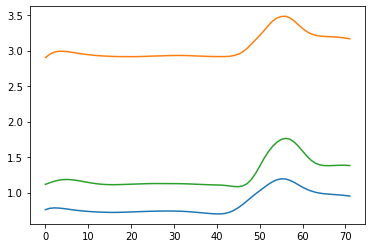

In [249]:
plt.plot(y_test_predicted[0])

In [250]:
vdata_in=x_test[0]
#y_test = y_test[0]
y_test_predicted = y_test_predicted[0]


t = np.arange(144+num_steps_to_predict)
n_steps_in = 144
t_in = np.arange(n_steps_in)
t_predict = t[n_steps_in:]-1
figsize = (10,5)

In [251]:
y_test_predicted.shape, vdata_out.shape

((72, 3), (1, 72, 3))

Text(0.5, 1.0, 'title')

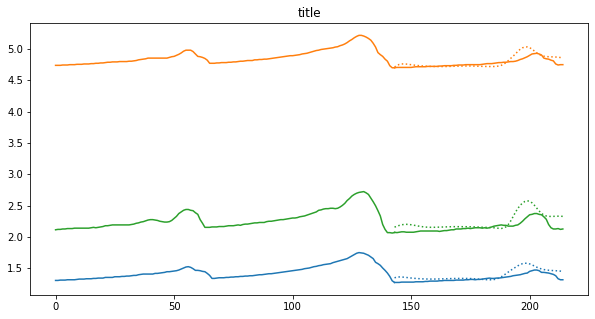

In [253]:
plt.figure(figsize=(10,5))
clr= ['C0', 'C1', 'C2']
for i in range(3):
    plt.plot(t_in, vdata_in[:,i]* std1[i] + mean1[i],color=clr[i])
    plt.plot(t_predict, vdata_out[0][:,i]* std1[i] + mean1[i], color=clr[i])
    plt.plot(t_predict, y_test_predicted[:,i]* std1[i] + mean1[i],color=clr[i], linestyle =':') #orange --> pre
plt.title('title')